In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce RTX 2060


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.01
adam_lr = 0.01

In [6]:
class PINN():
    def __init__(self, X, Y, layers, h, l, r, nu):
        self.x_dom = torch.tensor(X['dom'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_dom = torch.tensor(Y['dom'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_left = torch.tensor(X['left'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_left = torch.tensor(Y['left'], requires_grad=True).float().to(device).view(-1, 1)
        
        self.x_top = torch.tensor(X['top'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_top = torch.tensor(Y['top'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_right = torch.tensor(X['right'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_right = torch.tensor(Y['right'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_down = torch.tensor(X['down'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_down = torch.tensor(Y['down'], requires_grad=True).float().to(device).view(-1, 1)

        self.x_hole = torch.tensor(X['hole'], requires_grad=True).float().to(device).view(-1, 1)
        self.y_hole = torch.tensor(Y['hole'], requires_grad=True).float().to(device).view(-1, 1)

        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

        self.w_pde = 1
        self.w_bc = 1

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=5000,
            max_eval=5000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=2000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, y):
        out = self.dnn(torch.cat((x, y), dim=1))
        u = out[:,0].view(-1, 1)
        v = out[:,1].view(-1, 1)
        sxx = out[:,2].view(-1, 1)
        syy = out[:,3].view(-1, 1)
        sxy = out[:,4].view(-1, 1)
        return u, v, sxx, syy, sxy

    def pde_loss(self, x, y):
        u, v, sxx, syy, sxy = self.model_value(x, y)

        dx_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        dy_u = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
        dx_v = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        dy_v = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]

        dx_sxx = torch.autograd.grad(sxx, x, torch.ones_like(sxx), create_graph=True)[0]
        dy_syy = torch.autograd.grad(syy, y, torch.ones_like(syy), create_graph=True)[0]
        dy_sxy = torch.autograd.grad(sxy, y, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = torch.autograd.grad(sxy, x, torch.ones_like(sxy), create_graph=True)[0]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, xl, yl, xt, yt, xr, yr, xd, yd, xh, yh):
        u_l, v_l, _, _, _ = self.model_value(xl, yl)
        _, _, _, syy_t, sxy_t = self.model_value(xt, yt)
        _, _, sxx_r, _, sxy_r = self.model_value(xr, yr)
        _, _, _, syy_d, sxy_d = self.model_value(xd, yd)
        _, _, sxx_h, syy_h, sxy_h = self.model_value(xh, yh)

        b = torch.mean(torch.pow(u_l, 2))
        b += torch.mean(torch.pow(v_l, 2))

        b += torch.mean(torch.pow(syy_t, 2))
        b += torch.mean(torch.pow(sxy_t, 2))

        b += torch.mean(torch.pow(sxx_r - 1, 2))
        b += torch.mean(torch.pow(sxy_r, 2))

        b += torch.mean(torch.pow(syy_d, 2))
        b += torch.mean(torch.pow(sxy_d, 2))


        nx = -(xh-self.l/2)/self.r
        ny = -(yh-self.h/2)/self.r
        tx = torch.mul(sxx_h, nx) + torch.mul(sxy_h, ny)
        ty = torch.mul(sxy_h, nx) + torch.mul(syy_h, ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    
    def loss_func(self):
        pde = self.pde_loss(self.x_dom, self.y_dom)
        bc = self.bc_loss(
            self.x_left, self.y_left, 
            self.x_top, self.y_top, 
            self.x_right, self.y_right, 
            self.x_down, self.y_down, 
            self.x_hole, self.y_hole
        )

        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(x, y)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [7]:
def generate_points(pd, pb, l, h, r):
    a = l / 2
    b = h / 2

    area = r**2 * np.pi
    p_new = int(pd * (1+area)) # Increase amount of points with percantage of circle covering

    dom = lhs(2, p_new)
    mask = np.sqrt((dom[:,0]*l - a)**2 + (dom[:,1]*h - b)**2) >= r
    dom = dom[mask]
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h

    left_x = np.zeros(pb)
    left_y = (lhs(1, pb) * h).flatten()


    top_x = (lhs(1, pb) * l).flatten()
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = (lhs(1, pb) * h).flatten()

    down_x = (lhs(1, pb) * l).flatten()
    down_y = np.zeros(pb)

    theta = np.random.uniform(0, 2*np.pi, pb)
    hole_x = a + r*np.cos(theta)
    hole_y = b + r*np.sin(theta)

    dom_x = np.hstack((dom_x, hole_x, left_x, top_x, right_x, down_x))
    dom_y = np.hstack((dom_y, hole_y, left_y, top_y, right_y, down_y))

    X = {'dom': dom_x, 'left': left_x, 'top': top_x, 'right': right_x, 'down': down_x, 'hole': hole_x}
    Y = {'dom': dom_y, 'left': left_y, 'top': top_y, 'right': right_y, 'down': down_y, 'hole': hole_y}
    return X, Y

In [11]:
l = 1
h = 1
r = 0.1
E = 1
nu = 0.3


X, Y = generate_points(10000, 500, l, h, r)

nodes = 64
layers = [2] + 6 * [nodes] + [5]

In [80]:
model = PINN(X, Y, layers, h, l, r, nu)

In [81]:
model.train(8000)

Epoch 0, Loss: 2.057850e+00
PDE: 2.063762e-01, BC: 1.851474e+00
Epoch 100, Loss: 2.862675e-01
PDE: 2.433379e-02, BC: 2.619337e-01
Epoch 200, Loss: 2.887367e-01
PDE: 2.525151e-02, BC: 2.634852e-01
Epoch 300, Loss: 2.637821e-01
PDE: 3.181458e-02, BC: 2.319675e-01
Epoch 400, Loss: 2.489795e-01
PDE: 3.184957e-02, BC: 2.171299e-01
Epoch 500, Loss: 2.672095e-01
PDE: 3.340985e-02, BC: 2.337997e-01
Epoch 600, Loss: 2.609121e-01
PDE: 3.161227e-02, BC: 2.292998e-01
Epoch 700, Loss: 2.517344e-01
PDE: 3.327044e-02, BC: 2.184640e-01
Epoch 800, Loss: 4.234299e-01
PDE: 6.462187e-02, BC: 3.588080e-01
Epoch 900, Loss: 2.597129e-01
PDE: 3.180124e-02, BC: 2.279117e-01
Epoch 1000, Loss: 2.517964e-01
PDE: 3.307246e-02, BC: 2.187240e-01
Epoch 1100, Loss: 6.632885e-01
PDE: 2.981634e-01, BC: 3.651251e-01
Epoch 1200, Loss: 2.534069e-01
PDE: 3.055363e-02, BC: 2.228533e-01
Epoch 1300, Loss: 2.972019e-01
PDE: 2.891715e-02, BC: 2.682848e-01
Epoch 1400, Loss: 2.535977e-01
PDE: 3.380050e-02, BC: 2.197972e-01
Epoch 1

In [82]:
# Save model
torch.save(model.dnn.state_dict(), "plate_hole_lbfgs_good.pth")

In [12]:
# Load model
model = PINN(X, Y, layers, h, l, r, nu)
model.dnn.load_state_dict(torch.load("plate_hole_good.pth", weights_only=True))

<All keys matched successfully>

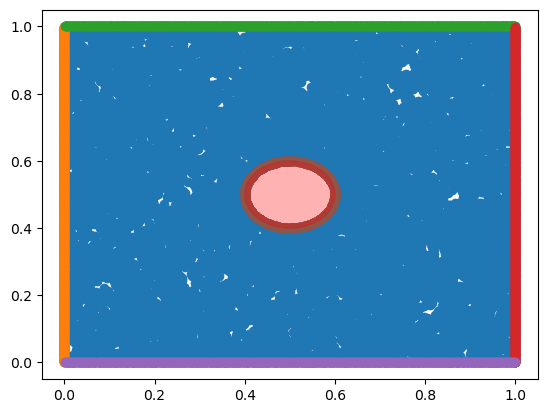

In [77]:
circle = plt.Circle((l/2, h/2), r, color='red', alpha=0.3)


figure, ax = plt.subplots()
ax.scatter(X['dom'], Y['dom'])
ax.scatter(X['left'], Y['left'])
ax.scatter(X['top'], Y['top'])
ax.scatter(X['right'], Y['right'])
ax.scatter(X['down'], Y['down'])
ax.scatter(X['hole'], Y['hole'])

ax.add_patch(circle)

plt.show()

In [ ]:
center = (l/2, h/2)
r = 0.1

x1, y1 = 0.5, 0.4


rn = np.sqrt((x1-l/2)**2 + (y1-h/2)**2)
n1 = -1*(x1 - l/2) / rn
n2 = -1*(y1 - h/2) / rn
print(n1, n2)


-0.0 1.0


In [26]:
x_p = 100
y_p = 100

x = np.linspace(0, l, x_p)
y = np.linspace(0, h, y_p)
X, Y = np.meshgrid(x, y)

points = np.vstack((X.ravel(), Y.ravel())).T

distances = np.sqrt((points[:, 0] - l/2)**2 + (points[:, 1] - h/2)**2)
filtered_points = points[distances > r]

# plt.figure(figsize=(8, 4))
# plt.scatter(filtered_points[:, 0], filtered_points[:, 1], s=1)
# circle = plt.Circle((l/2, h/2), r, color='r', fill=False)
# plt.gca().add_patch(circle)

# plt.xlim(0, l)
# plt.ylim(0, h)
# plt.gca().set_aspect('equal')
# plt.title("Grid of Points in Rectangular Domain with Circular Hole")
# plt.show()

x_pred = filtered_points[:, 0].reshape(-1, 1)
y_pred = filtered_points[:, 1].reshape(-1, 1)

u, v, sxx, syy, sxy = model.predict(x_pred, y_pred)

In [27]:
L = 1  # Length of the sheet
H = 1   # Height of the sheet
nx, ny = 10, 10  # Number of grid points in x and y
E = 7e10  # Young's modulus (Pa)
nu = 0.3   # Poisson's ratio
sigma_0 = 500e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


In [28]:
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
print(von_mises)

[[6.2311789e+08]
 [6.1559232e+08]
 [6.0861344e+08]
 ...
 [4.9732067e+08]
 [4.9727072e+08]
 [4.9718634e+08]]


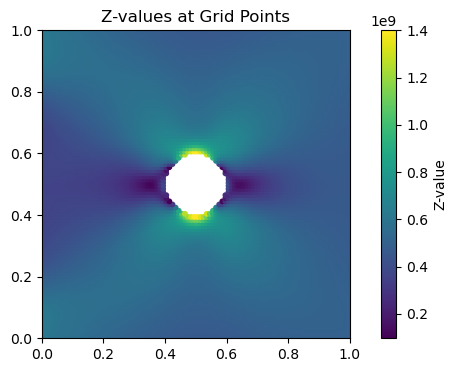

In [29]:
plt.figure(figsize=(8, 4))
sc = plt.scatter(x_pred, y_pred, c=von_mises, cmap='viridis', s=10)
plt.colorbar(sc, label="Z-value")
plt.title("Z-values at Grid Points")
plt.xlim(0, l)
plt.ylim(0, h)
plt.gca().set_aspect('equal')
plt.show()

In [14]:
import pandas as pd
import h5py


dataset = {
    'x': x_pred.flatten(),
    'y': y_pred.flatten(),
    'u': u.flatten(),
    'v': v.flatten(),
    'von_mises': von_mises.flatten(),
    'sxx': sxx.flatten(),
    'syy': syy.flatten(), 
    'sxy': sxy.flatten()
}

df = pd.DataFrame(dataset)


NameError: name 'x_pred' is not defined

In [19]:
points = df[['x', 'y']].values

s_mises = df['von_mises'].values
s11 = df['sxx'].values
s22 = df['syy'].values
s12 = df['sxy'].values


h5_file = "output2.h5"
with h5py.File(h5_file, 'w') as f:
    f.create_dataset("coordinates", data=points)
    f.create_dataset("SMises", data=s_mises)
    f.create_dataset("S11", data=s11)
    f.create_dataset("S22", data=s22)
    f.create_dataset("S12", data=s12)


xdmf_file = "output2.xdmf"
xdmf_content = f"""<?xml version="1.0" ?>
<Xdmf Version="3.0">
    <Domain>
        <Grid Name="Mesh" GridType="Uniform">
            <Topology TopologyType="Polyvertex" NumberOfElements="{len(points)}"/>
            <Geometry GeometryType="XY">
                <DataItem Format="HDF" DataType="Float" Dimensions="{len(points)} 2">{h5_file}:/coordinates</DataItem>
            </Geometry>
            <Attribute Name="SMises" AttributeType="Scalar" Center="Node">
                <DataItem Format="HDF" DataType="Float" Dimensions="{len(points)}">{h5_file}:/SMises</DataItem>
            </Attribute>
            <Attribute Name="S11" AttributeType="Scalar" Center="Node">
                <DataItem Format="HDF" DataType="Float" Dimensions="{len(points)}">{h5_file}:/S11</DataItem>
            </Attribute>
            <Attribute Name="S22" AttributeType="Scalar" Center="Node">
                <DataItem Format="HDF" DataType="Float" Dimensions="{len(points)}">{h5_file}:/S22</DataItem>
            </Attribute>
            <Attribute Name="S12" AttributeType="Scalar" Center="Node">
                <DataItem Format="HDF" DataType="Float" Dimensions="{len(points)}">{h5_file}:/S12</DataItem>
            </Attribute>
        </Grid>
    </Domain>
</Xdmf>
"""


with open(xdmf_file, "w") as f:
    f.write(xdmf_content)

print("XDMF file saved as output.xdmf")

XDMF file saved as output.xdmf


In [15]:
csv_file = "test_data.csv"
df = pd.read_csv(csv_file, sep=";", skipinitialspace=True)

In [16]:
x_fem = df['X'].values.reshape(-1, 1)
y_fem = df['Y'].values.reshape(-1, 1)

u, v, sxx, syy, sxy = model.predict(x_fem, y_fem)

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


0.07990439429207864


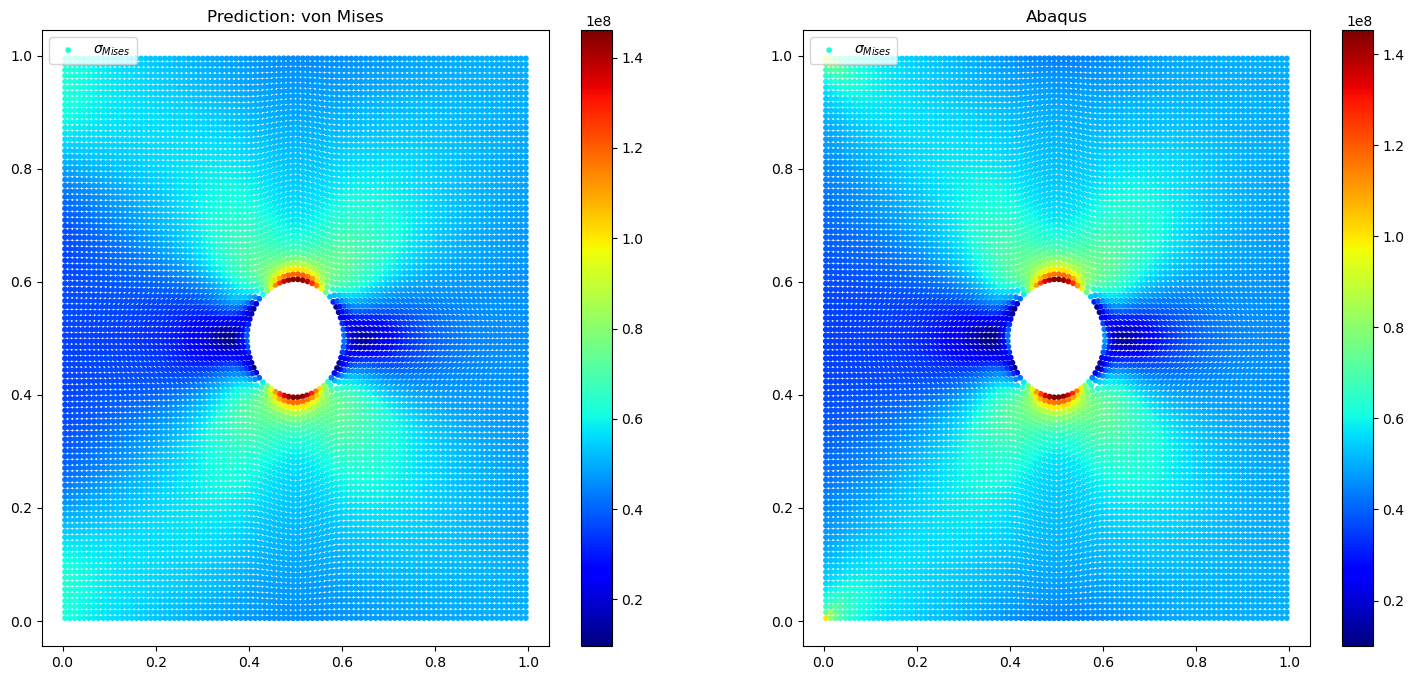

In [24]:
sxx_fem = df['S-Mises'].values.reshape(-1, 1)
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
sxx_error = np.abs(von_mises - sxx_fem)
l2_error = np.linalg.norm(sxx - sxx_fem) / np.linalg.norm(sxx_fem, 2)
print(l2_error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

color_map = 'jet'

sc1 = ax1.scatter(x_fem, y_fem, c=von_mises, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax1.legend(loc='upper left')
ax1.set_title('Prediction: von Mises')

plt.colorbar(sc1)

sc2 = ax2.scatter(x_fem, y_fem, c=sxx_fem, cmap=color_map, s=10, label=r'$\sigma_{Mises}$')
ax2.legend(loc='upper left')
ax2.set_title('Abaqus')
plt.colorbar(sc2)


plt.show()

In [18]:
mises_pred = von_mises
mises_abaqus = df['S-Mises'].values.reshape(-1, 1)

max_pred = np.max(mises_pred)
max_abaqus = np.max(mises_abaqus)

m_pred = np.mean(mises_pred)
m_abaqus = np.mean(mises_abaqus)

factor_pred = max_pred / m_pred
factor_abaqus = max_abaqus / m_abaqus

print(f"My model: {factor_pred}")
print(f"Abaqus: {factor_abaqus}")

My model: 2.823540687561035
Abaqus: 2.8129607579943294


In [19]:
d = 0.2
H = 1

K = 0.284 + 2 / (1 - d/H) - 0.6*(1-d/H) + 1.32*(1-d/H)**2
print(K*(1-d/H))

2.5190400000000004


92.0


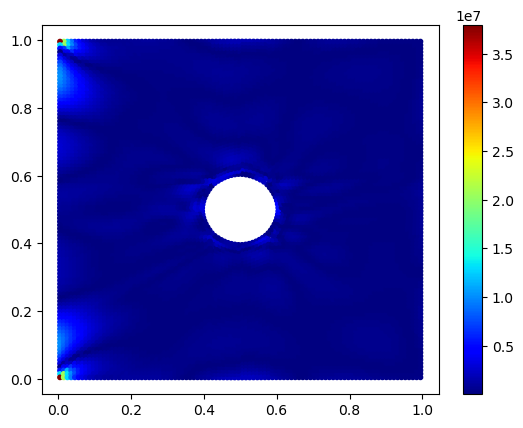

In [22]:
error = np.abs(mises_pred - mises_abaqus)
print(np.min(error))
s = plt.scatter(x_fem, y_fem, c=error, cmap=color_map, s=10)
plt.colorbar(s)

In [1]:
print(np.min(error), np.max(error))

NameError: name 'np' is not defined